In [1]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

/var/folders/sh/1qclfzm54zlgld8yp8_l0bbh0000gn/T/ipykernel_93507/4157211178.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial6"

pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cpu


In [3]:
# download two pre-trained models

import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

### What is Attention? 
The attention mechanism describes a recent new group of layers in neural networks that has attracted a lot of interest in the past few years, especially in sequence tasks. <br>

*The attention mechanism describes a weighted average of (sequence) elements with the weights dynamically computed based on an input query and elements’ keys.* We want to dynamically decide on which inputs we want to “attend” more than others. <br>

There are 4 usual parts: 
1. **Query**: feature vector that describes what we are looking for in the sequence i.e. what we maybe want to pay attention to
2. **Keys**: for each input element, we have a key (a feature vector); roughly describes what this element is "offering" or when it might be important. Keys should be designed in a way in which we can identify the elements we want to pay attention to based on the query.
3. **Values**: for each input element, we have a value vector. This is the feature vector that we want to average over.
4. **Score Function**: to rate which elements we want to pay attention to, need to specify the scope function $f_{attn}$. Score function takes the query and the keys as input, and the output score/attention weight of the query-key pair. Usually implemented by simple metrics such as the dot product or a small MLP. <br>

The weights of the avg are calculated by a softmax over all score function inputs. Hence, we assign those value vectors a higher weight whose corresponding key is most similar to the query.

The attention applied inside the Transformer architecture is called **self-attention**.

### Scaled Dot Product Attention
Allows for a network to attend over a sequence.

In [4]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1] # hidden dimensionality of query and keys
    attn_logits = torch.matmul(q, k.transpose(-2,-1)) # swaps the last and second to last dim
    attn_logits = attn_logits / math.sqrt(d_k) # to scale dot product variance back down to original variance of Q and K
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15) # fill elements of attn_logits to -9e15 where mask == 0
                                                                # shape of mask must be broadcastable with underlying tensor
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [5]:
seq_len, d_k = 3, 2
q = torch.rand(seq_len, d_k)
k = torch.rand(seq_len, d_k)
v = torch.rand(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention) # will have dim (seq_len, seq_len)

Q
 tensor([[0.8823, 0.9150],
        [0.3829, 0.9593],
        [0.3904, 0.6009]])
K
 tensor([[0.2566, 0.7936],
        [0.9408, 0.1332],
        [0.9346, 0.5936]])
V
 tensor([[0.8694, 0.5677],
        [0.7411, 0.4294],
        [0.8854, 0.5739]])
Values
 tensor([[0.8375, 0.5288],
        [0.8404, 0.5323],
        [0.8365, 0.5282]])
Attention
 tensor([[0.2993, 0.2992, 0.4015],
        [0.3549, 0.2729, 0.3723],
        [0.3311, 0.3021, 0.3668]])


### Multi-Head Attention

Often there are multiple different aspects a sequence element wants to attend to, and a single weighted average is not a good option for it.This is why we extend the attention mechanisms to multiple heads, i.e. multiple different query-key-value triplets on the same features. Given a query, key, and value matrix, we transform those into sub-queries, sub-keys, and sub-values, which we pass through the scaled dot product attention independently. Afterward, we concatenate the heads and combine them with a final weight matrix. 

In [33]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

Multi-head attention is looking at the input as a set, rather than a sequence (permutation-equivariant with respect to inputs). If it is important for the task to consider order, then it is common to encode the position in the input features. Compared to RNNs, self-attention layers can parallelize all of its operations making it much faster to compute for smaller sequence lengths. When the sequence length exceeds the hidden dimensionality, self-attention is more expensive to compute than an RNN.

### Transformer Encoder
Originally, the Transformer model was designed for machine translation. Hence, it got an encoder-decoder structure where the encoder takes as input the sentence in the original language and generates an attention-based representation. On the other hand, the decoder attends over the encoded information and generates the translated sentence in an autoregressive manner, as in a standard RNN. <br>

The encoder consists of $N$ identical blocks that are applied in sequence. The input $x$ is passed through a Multi-Head Attention layer. The output is then added to the original input using a residual connection and then a Layer Norm is applied. The residual connection is important for two reasons:
1. Transformers are designed to be very deep. Residual connections are crucial for enabling smooth gradient flow through the model.
2. W/o residual connection, info about the original sequence is lost. <br>

Layer Norm enables faster training and provides small regularization. It also ensures that features are in a similar magnitude among the elements in a sequence. Batch Norm is NOT used becuase it depends on the batch size, which is normally very small for Transformers. <br>

In addition to Multi-head Attention, a small fully connected feed-forward network is added to the model, which is applied to each position separately and identically. Can see this MLP as a post-process to prepare it for the next attention block. Usually, the dimensionality of this MLP is 2 to 8 times larger then $d_{model}$. General advantage of a wider layer instead of a narrow, multi-layer MLP is the faster, parallelizable execution.

In [7]:
class EncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attentionlayer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-Layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP Part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2

        return x

In [31]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask)
        return x

    def get_attention_maps(self, x, mask=None):
        """
        return the attention probabilities for all Multi-Head Attention blocks in the encoder.
        """
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

### Positional Encoding
The position information can therefore be added via the input features. We could learn a embedding for every possible position, but this would not generalize to a dynamical input sequence length. Hence, the better option is to use feature patterns that the network can identify from the features and potentially generalize to larger sequences. The specific pattern chosen by Vaswani et al. are sine and cosine functions of different frequencies.

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # create a matrix of [seq_len, hidden_dim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) # double colon is seq of each n-th item starting from x
                                                     # in this case, every 2nd element starting from 0 (so evens) 
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # this adds a 1 @ dim 0

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

EncodeBlock PE size = torch.Size([1, 96, 48])
PE Size = (48, 96)


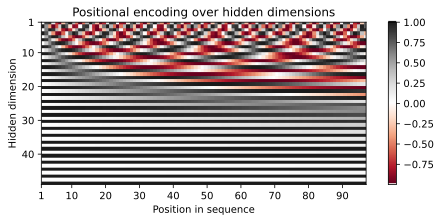

In [10]:
# visualize the positional encoding
encode_block = PositionalEncoding(d_model=48, max_len=96)
print(f"EncodeBlock PE size = {encode_block.pe.size()}")
pe = encode_block.pe.squeeze().T.cpu().numpy()
print(f"PE Size = {pe.shape}")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

You can clearly see the sine and cosine waves with different wavelengths that encode the position in the hidden dimensions.

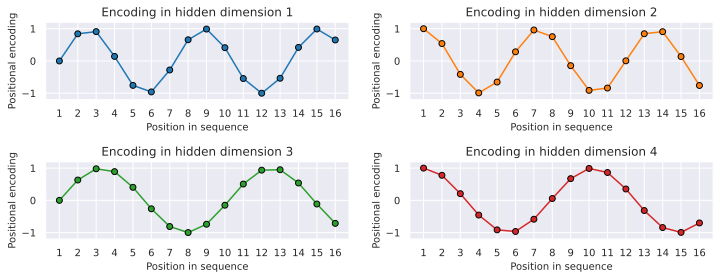

In [11]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

### Learning rate warm-up

A common technique for training Transformers. Gradually increase LR from 0 to original specified LR. Slowly start learning instead of taking very large steps from the beginning. In fact, w/o this, a Transformer can diverge and achieve bad performance. 

In [12]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch / self.warmup
        return lr_factor

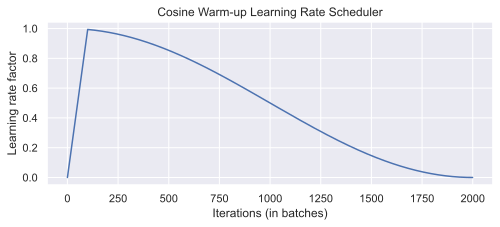

In [13]:
# initialize the LR scheduler
p = nn.Parameter(torch.empty(4,4)) # needed for dummy plot
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

### PyTorch Lightning Module

In [27]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.hparams.warmup,
                                             max_iters=self.hparams.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

### Experiments

#### Sequence to Sequence

A Sequence-to-Sequence task represents a task where the input and the output is a sequence, not necessarily of the same length. Popular tasks in this domain include machine translation and summarization. For this, we usually have a Transformer encoder for interpreting the input sequence, and a decoder for generating the output in an autoregressive manner. Here, however, we will go back to a much simpler example task and use only the encoder. Given a sequence of numbers between and , the task is to reverse the input sequence. Although this task sounds very simple, RNNs can have issues with such because the task requires long-term dependencies. Transformers are built to support such, and hence, we expect it to perform very well.

In [15]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

In [16]:
dataset = partial(ReverseDataset, 10, 16) # omit size using partial
train_loader = data.DataLoader(dataset(50000), 
                               batch_size=128, 
                               shuffle=True, 
                               drop_last=True, 
                               pin_memory=True)
val_loader = data.DataLoader(dataset(1000), batch_size=128)
test_loader = data.DataLoader(dataset(10000), batch_size=128)

In [17]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([7, 6, 9, 6, 3, 1, 9, 3, 1, 9, 7, 9, 2, 0, 5, 9])
Labels:     tensor([9, 5, 0, 2, 9, 7, 9, 1, 3, 9, 1, 3, 6, 9, 6, 7])


In [18]:
class ReversePredictor(TransformerPredictor):
    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logging
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [29]:
def train_reverse(**kwargs):
    # create PyTorch Lightning trainer with generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")
    os.makedirs(root_dir, exist_ok=True)

    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=10,
                         gradient_clip_val=5,
                         progress_bar_refresh_rate=1)
    trainer.logger._default_hp_metric = None # optional logging arg that is not needed

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask.ckpt")
    if os.path.isfile(pretrained_filename) and False:
        print("Found pretrained model, loading...")
        model = ReversePredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = ReversePredictor(max_iters=trainer.max_epochs*len(train_loader), **kwargs)
        trainer.fit(model, train_loader, val_loader)

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

In [34]:
reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              num_heads=1,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | input_net           | Sequential         | 352   
1 | positional_encoding | PositionalEncoding | 0     
2 | transformer         | TransformerEncoder | 1.2 K 
3 | output_net          | Sequential         | 1.4 K 
-----------------------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2048x32 and 10x30)